In [1]:
!date

Tue Jul 27 22:20:31 PDT 2021


# Subclass DE isoform only [GLUT]

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
subclass_cmap = pd.read_csv('../../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [4]:
gene = anndata.read_h5ad("../../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../../data/notebook/revision/isoform.h5ad")

In [5]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [6]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [7]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [8]:
gene          = gene[gene.obs.class_label=="Glutamatergic"]
isoform = isoform[isoform.obs.class_label=="Glutamatergic"]

In [9]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.gene_name.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

27-Jul-21 22:22:01 - 1 of 29 assignments: CA1-ProS
27-Jul-21 22:22:03 - 2 of 29 assignments: CA3
27-Jul-21 22:22:07 - 3 of 29 assignments: CR
27-Jul-21 22:22:10 - 4 of 29 assignments: CT SUB
27-Jul-21 22:22:12 - 5 of 29 assignments: Car3
27-Jul-21 22:22:15 - 6 of 29 assignments: DG
27-Jul-21 22:22:17 - 7 of 29 assignments: IG-FC
27-Jul-21 22:22:20 - 8 of 29 assignments: L2  IT ENTl
27-Jul-21 22:22:23 - 9 of 29 assignments: L2 IT ENTm
27-Jul-21 22:22:26 - 10 of 29 assignments: L2/3 IT CTX
27-Jul-21 22:22:29 - 11 of 29 assignments: L2/3 IT ENTl
27-Jul-21 22:22:32 - 12 of 29 assignments: L2/3 IT PPP
27-Jul-21 22:22:34 - 13 of 29 assignments: L2/3 IT RHP
27-Jul-21 22:22:37 - 14 of 29 assignments: L3 IT ENT
27-Jul-21 22:22:40 - 15 of 29 assignments: L4 RSP-ACA
27-Jul-21 22:22:43 - 16 of 29 assignments: L4/5 IT CTX
27-Jul-21 22:22:45 - 17 of 29 assignments: L5 IT CTX
27-Jul-21 22:22:48 - 18 of 29 assignments: L5 IT TPE-ENT
27-Jul-21 22:22:52 - 19 of 29 assignments: L5 NP CTX
27-Jul-21 22:22:

CPU times: user 48.9 s, sys: 36.8 s, total: 1min 25s
Wall time: 1min 25s


In [10]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

27-Jul-21 22:23:31 - 1 of 29 assignments: CA1-ProS
27-Jul-21 22:23:36 - 2 of 29 assignments: CA3
27-Jul-21 22:23:41 - 3 of 29 assignments: CR
27-Jul-21 22:23:45 - 4 of 29 assignments: CT SUB
27-Jul-21 22:23:48 - 5 of 29 assignments: Car3
27-Jul-21 22:23:52 - 6 of 29 assignments: DG
27-Jul-21 22:23:56 - 7 of 29 assignments: IG-FC
27-Jul-21 22:24:00 - 8 of 29 assignments: L2  IT ENTl
27-Jul-21 22:24:05 - 9 of 29 assignments: L2 IT ENTm
27-Jul-21 22:24:09 - 10 of 29 assignments: L2/3 IT CTX
27-Jul-21 22:24:12 - 11 of 29 assignments: L2/3 IT ENTl
27-Jul-21 22:24:16 - 12 of 29 assignments: L2/3 IT PPP
27-Jul-21 22:24:21 - 13 of 29 assignments: L2/3 IT RHP
27-Jul-21 22:24:25 - 14 of 29 assignments: L3 IT ENT
27-Jul-21 22:24:28 - 15 of 29 assignments: L4 RSP-ACA
27-Jul-21 22:24:32 - 16 of 29 assignments: L4/5 IT CTX
27-Jul-21 22:24:36 - 17 of 29 assignments: L5 IT CTX
27-Jul-21 22:24:41 - 18 of 29 assignments: L5 IT TPE-ENT
27-Jul-21 22:24:45 - 19 of 29 assignments: L5 NP CTX
27-Jul-21 22:24:

CPU times: user 58.7 s, sys: 1min 9s, total: 2min 8s
Wall time: 2min 8s


# Look at isoform markers

In [11]:
alpha = 0.01
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es").tail()

,index,name,p_raw,p_corr,es
1907708,L6 IT ENTl,Mgp-201_ENSMUST00000032342.3,1.39791e-48,5.24217e-45,6.15666
1529301,L5 NP CTX,Myl4-202_ENSMUST00000106956.10,1.92101e-165,4.86785e-162,6.19675
385325,Car3,Synpr-202_ENSMUST00000112656.4,0,2.22507e-308,6.31637
987545,L2/3 IT RHP,Dcn-201_ENSMUST00000105287.11,5.19534e-94,1.68017e-90,6.7113
1558184,L5 PPP,Nts-201_ENSMUST00000020040.5,3.13073e-11,8.44985e-08,7.04482


In [12]:
markers_gene[markers_gene.name.str.contains('Crhbp')]

,index,name,p_raw,p_corr,es


In [13]:
specific_cluster = "L6 IT ENTl"
specific_isoform = "Mgp-201_ENSMUST00000032342.3"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [14]:
specific_gene

'Mgp'

In [15]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

['Mgp_ENSMUSG00000030218.3']
Categories (26154, object): ['5S_rRNA_ENSMUSG00000118681.1', '5S_rRNA_ENSMUSG00000118725.1', '5S_rRNA_ENSMUSG00000118727.1', '5S_rRNA_ENSMUSG00000118747.1', ..., 'n-R5s25_ENSMUSG00000064857.3', 'n-R5s41_ENSMUSG00000064959.3', 'n-R5s173_ENSMUSG00000064554.3', 'n-R5s185_ENSMUSG00000065887.2']

In [16]:
isoform.var[isoform.var.gene_name.str.contains(specific_gene+"_")].transcript_name.values

array(['Mgp-201_ENSMUST00000032342.3'], dtype=object)

In [17]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [18]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")

    
    return ax


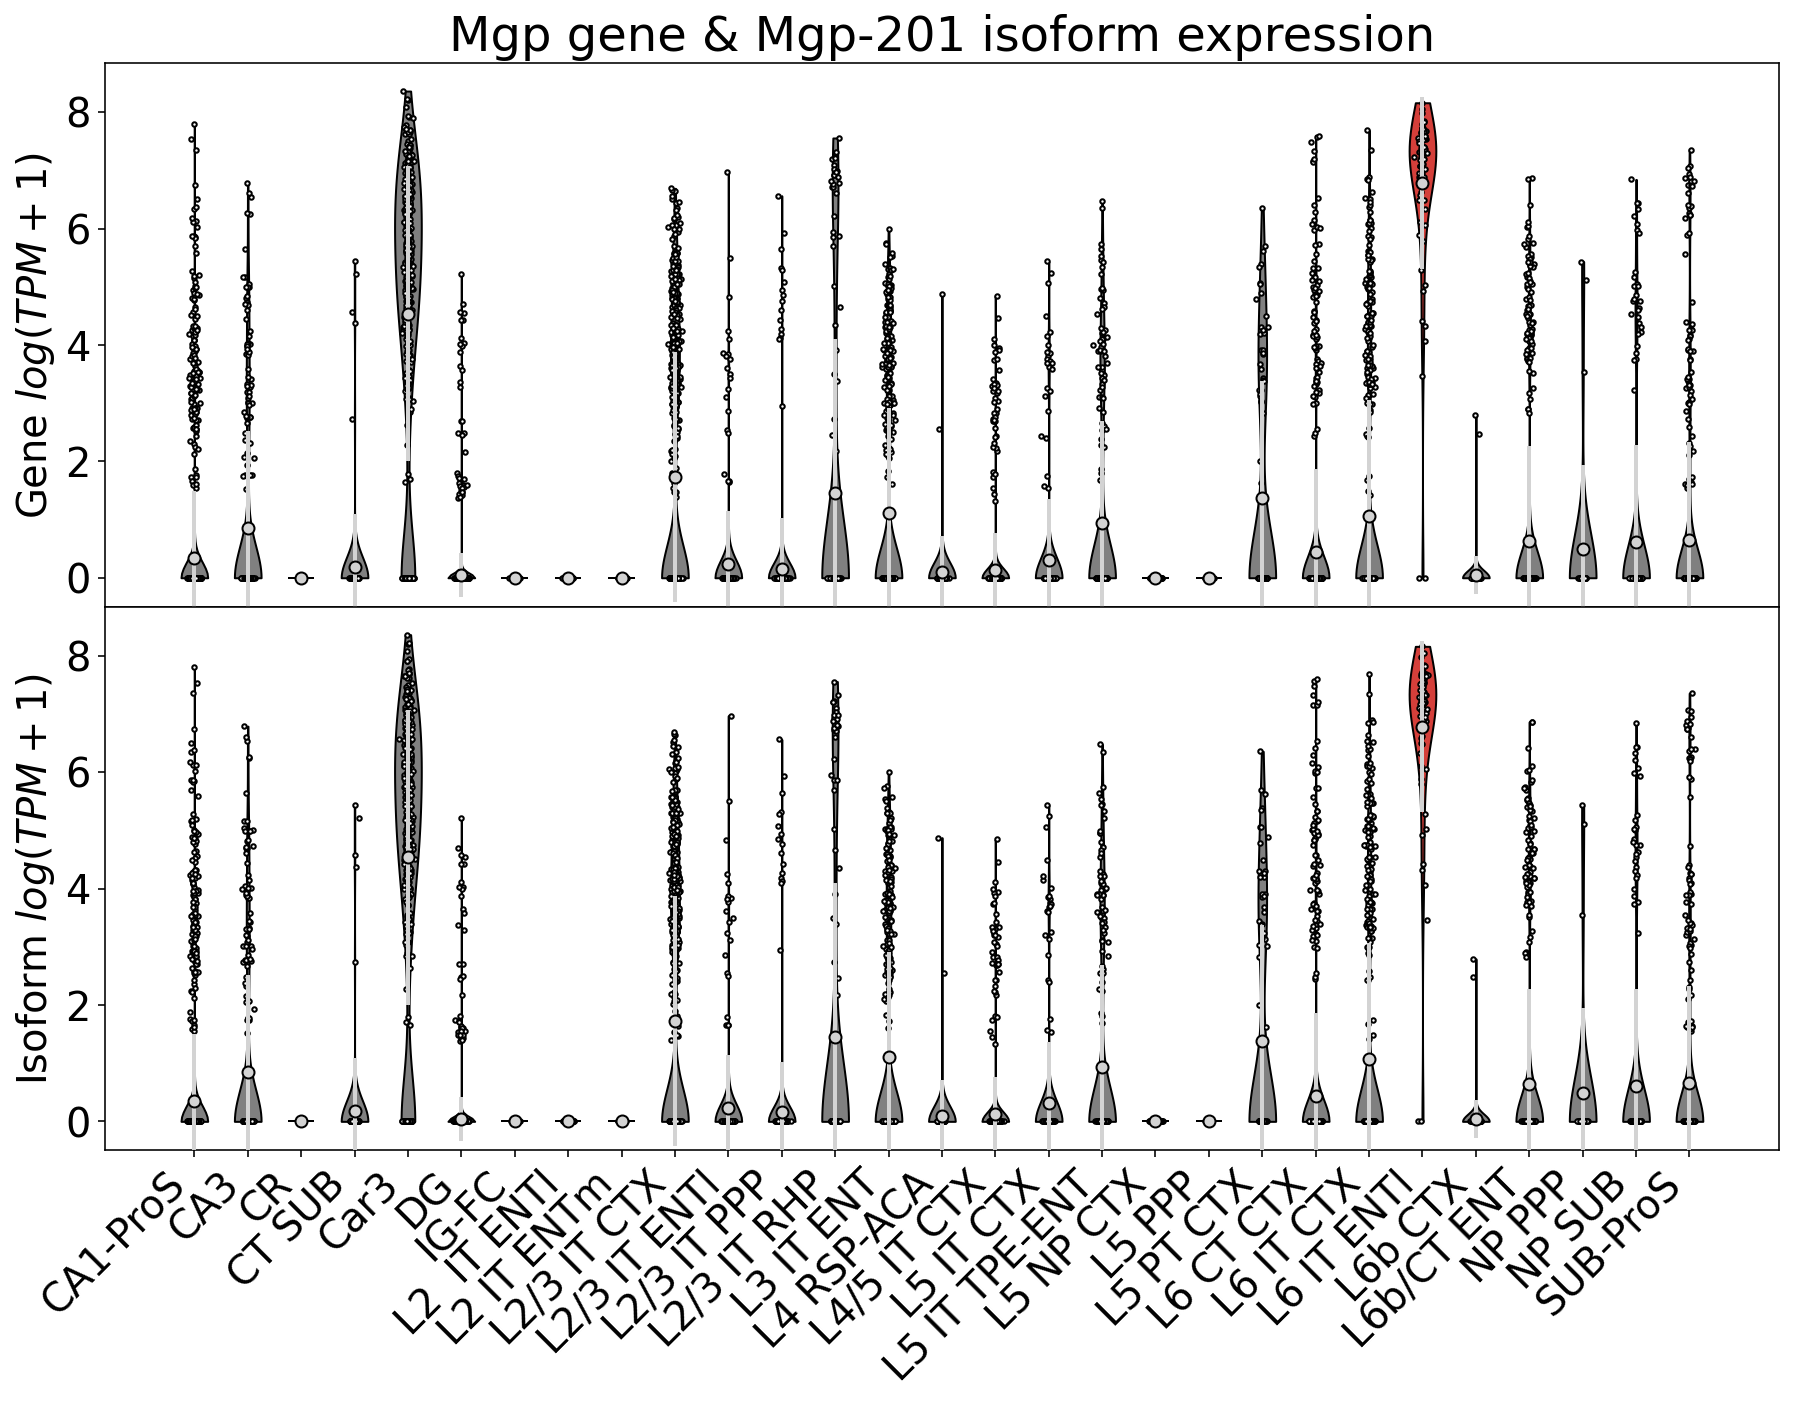

In [19]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)


######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.subclass_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})

plt.savefig("../../../figures/subclass_DE_isoform_only_violin_{}-GLUT.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

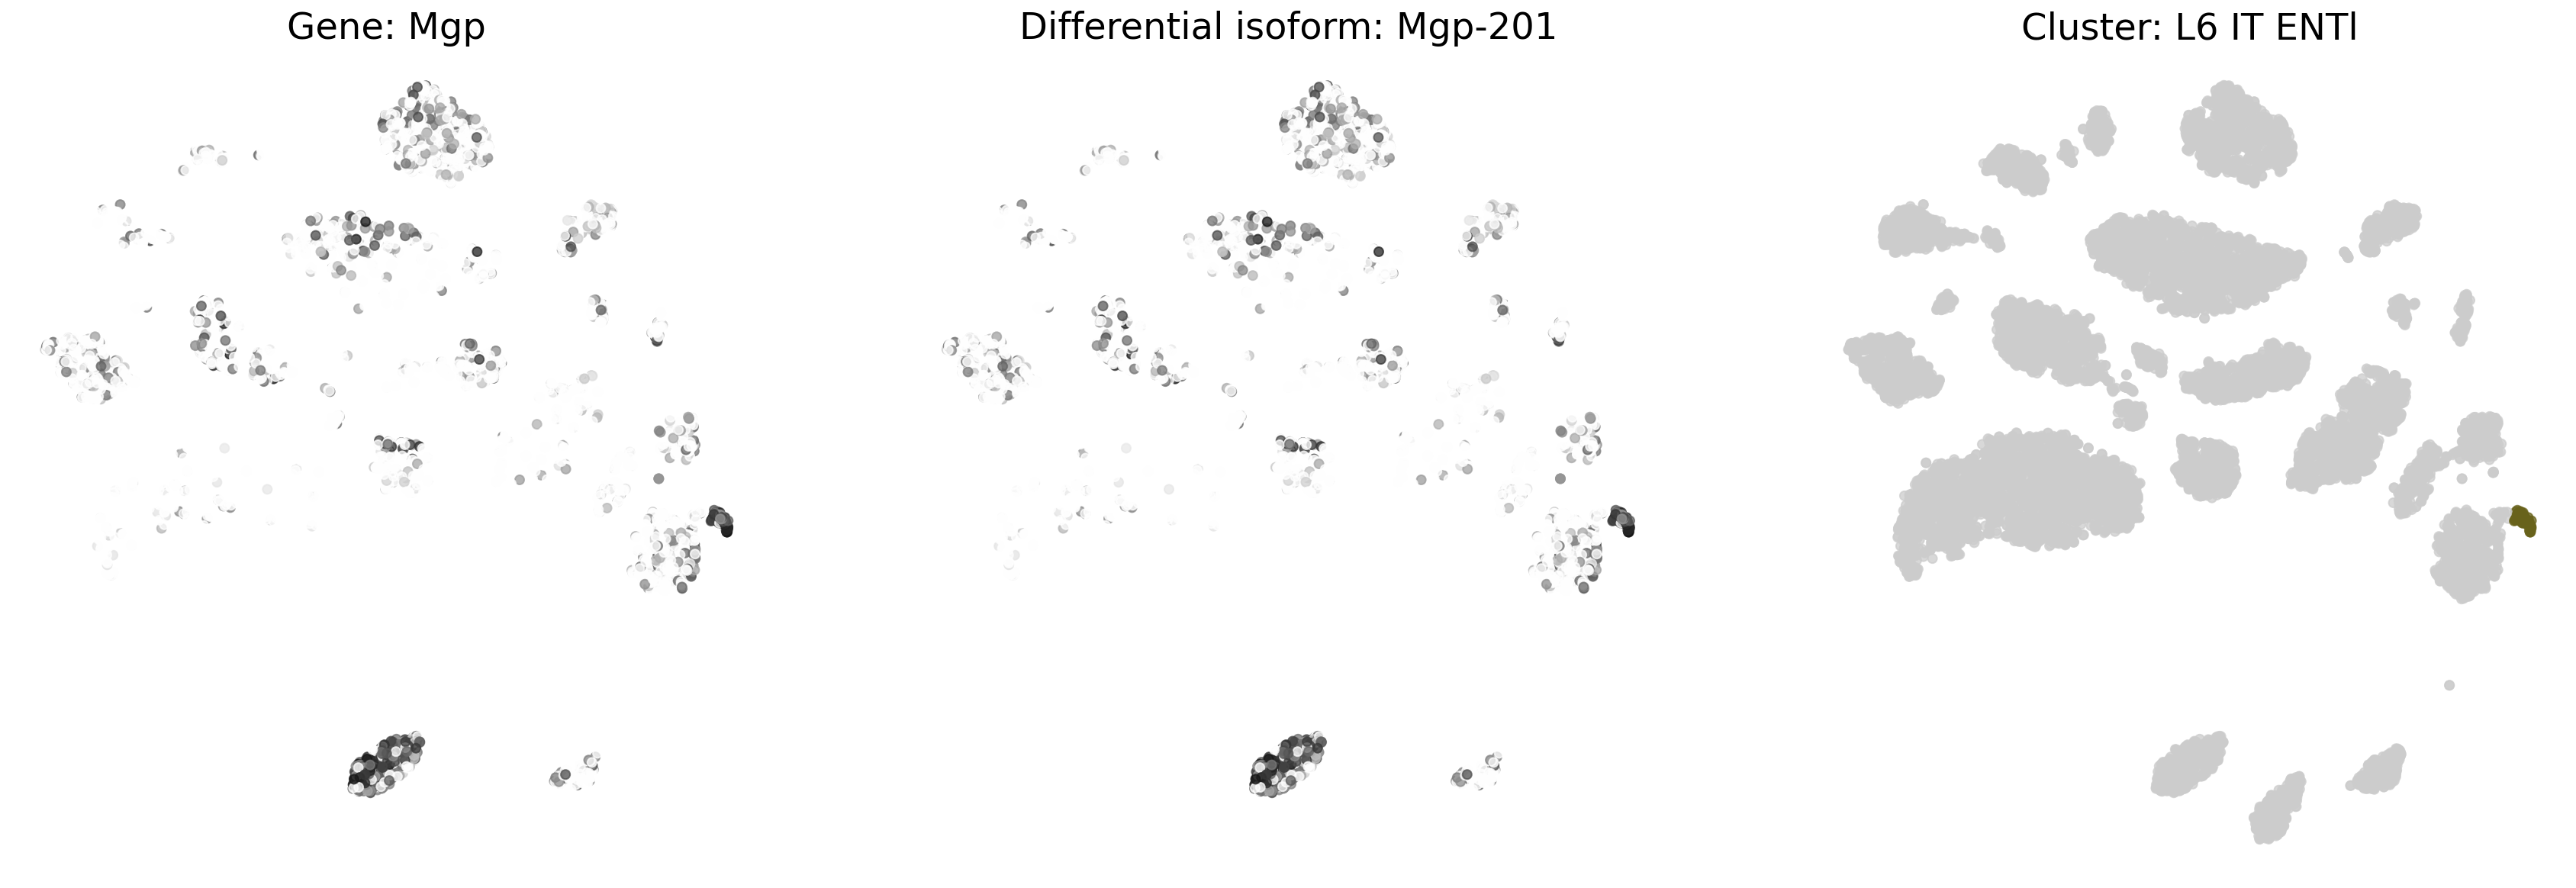

In [20]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(gene.obs["subclass_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster.split("_")[0]))
plt.savefig("../../../figures/subclass_DE_isoform_only_nca_{}-GLUT.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [21]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [22]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

In [23]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

41010 isoforms from 5258 genes identified.


In [24]:
markers_isoform.to_csv("../../../tables/unordered/subclass_DE_isoform_only-GLUT.csv")